# making an aggregate master dataframe for baseline model  10/22/18 -11/6/18
this notebook is going to make standardized longformat dataframes for each dataframe that i will adjust for each model to. 

for my first pass, i will work to establish a baseline model by using:
the single "worst", or value that most indicates poor clinical outcomes, for each variable so each variable only has one row per patient. 


- make a long format table(ie variable, patient, time, value)
 - step1:Standardize all columns, format, etc. 
 - step2: Maybe make a long format table for each dataframe
 - step3: Impute
 
- combine features from each long table for 1 wide table (ie each patient has a row, each parameter has a column). 
 - feature select for "Clinical worst case" 



- Establish a baseline (ie train model initially), using an obvious baseline: last valid mesurement of a particular variable.   Will hope that it doesn’t perform too good or too bad. Second would be to pick an aggregate within a time window (over 3 days, or of each day, ie can change graunlarity).

- Next try temporal trend, maybe vector autoregression. 

So my first step would be to pick either the last recorded value for each variable or the ‘worst’ value, or ones that we might expect to indicate poor outcome (NEED TO CHOOSE)


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
import numpy as np
import glob

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 38.8 ms


In [78]:
#cohort import

os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'


final_pt_df2 = pd.read_csv(Path(wd + '/data/raw/csv/01102018_final_pt_df2_v.csv') , index_col=0) #only for patients with minimum vitals
patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 105 ms


In [3]:
# #adding this in fow now, will eventually want to switch this to the 03-clinical_variables_final
# import psycopg2
# import getpass
# conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
#                         password=getpass.getpass(prompt='Password:'.format()))
# cur=conn.cursor()

# query_schema = 'SET search_path to ' + "mimiciii" + ';'

Password: ·····


time: 1.97 s


In [ ]:
#import all clinical variables
##ensure they are the versions with UOM

In [81]:
#importing in all clinical_variable files
date= '14112018'
os.chdir(r'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/')
allFiles = glob.glob(os.getcwd() + "/{}_*.csv".format(date))

time: 2.27 ms


In [12]:
os.getcwd()

'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed'

time: 2.41 ms


In [82]:
allFiles  #need to rerun 03.1-clinical_variables and have a new date to make it easier. 

['/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_rrt_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_vitals_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_ventcategory_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_sofa_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_bg_all_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_gcs_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_phenylephrine_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_epinephrine_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/14112018_bg_ART_prepp

time: 2.11 ms


In [83]:
test_string=allFiles[1]

time: 629 µs


In [84]:
df_list=[]

for element in allFiles:
    df_list.append(element.split('{}_'.format(date))[1].split('_prepped.csv')[0])

time: 1.44 ms


In [41]:
df_list

['rrt',
 'vitals',
 'ventcategory',
 'sofa',
 'bg_all',
 'gcs',
 'phenylephrine',
 'epinephrine',
 'bg_ART',
 'norepinephrine',
 'o2_flow',
 'labs',
 'vasopressin',
 'uti',
 'dopamine',
 'dobutamine',
 'weight']

time: 2.95 ms


In [85]:
#making a dictionary of all my dataframes for easier cycling through
##first gen df_list, has been rewritten
# df_list=[
#     'bg_ART', 'uti', 'weight',
#     'vaso', 'labs', 'height',
#     'ventcategory', 'gcs', 'vitals',
#     'bg_all', 'sofa', 'rrt']

# df_list=['rrt', 
#     'phenylephrine','epinephrine','dopamine',
#     'dobutamine','norepinephrine','vasopressin',
#     'o2_flow','bg_ART', 'uti',
#     'weight','labs','ventcategory', 
#     'gcs', 'vitals','bg_all',
#     'sofa', 'rrt']

df_list=[]

for element in allFiles:
    df_list.append(element.split('{}_'.format(date))[1].split('_prepped.csv')[0])

dfs = {}
i=0
for name in df_list:
    dfs[name] = pd.read_csv(allFiles[i],  index_col=0)
    i+=1

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 13.4 s


In [86]:
#all of the column names 
for element in df_list:
    print(element,':',list(dfs[element]))

rrt : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
vitals : ['subject_id', 'hadm_id', 'icustay_id', 'charttime', 'uom', 'label', 'value', 't_0', 'delta']
ventcategory : ['icustay_id', 'uom', 't_0', 'label', 'value', 'delta']
sofa : ['subject_id', 'hadm_id', 'icustay_id', 'delta', 'label', 'value', 't_0', 'uom']
bg_all : ['subject_id', 'hadm_id', 'icustay_id', 'charttime', 'delta', 't_0', 'label', 'valuenum', 'uom']
gcs : ['subject_id', 'hadm_id', 'icustay_id', 'delta', 'label', 'value', 't_0', 'uom']
phenylephrine : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
epinephrine : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
bg_ART : ['subject_id', 'hadm_id', 'icustay_id', 'charttime', 'delta', 't_0', 'label', 'valuenum', 'uom']
nit : ['subject_id', 'hadm_id', 't_0', 'label', 'value', 'delta', 'icustay_id', 'uom']
norepinephrine : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
o2_flow : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
labs : ['

## standardizing columns

#### adding icustay_id, dropping hadm_id

In [87]:
##dropping hadm_id from all:
list1=[]
for element in df_list:
    if 'hadm_id' in (list(dfs[element])):
        list1.append(element)

for element in list1:
    dfs[element]= dfs[element].drop('hadm_id', axis=1)

time: 557 ms


In [88]:
##dropping subject_id from all:
list1=[]
for element in df_list:
    if 'subject_id' in (list(dfs[element])):
        list1.append(element)

for element in list1:
    dfs[element]= dfs[element].drop('subject_id', axis=1)

time: 482 ms


In [89]:
#all of the column names 
for element in df_list:
    print(element,':',sorted(list(dfs[element])))

rrt : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
vitals : ['charttime', 'delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
ventcategory : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
sofa : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
bg_all : ['charttime', 'delta', 'icustay_id', 'label', 't_0', 'uom', 'valuenum']
gcs : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
phenylephrine : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
epinephrine : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
bg_ART : ['charttime', 'delta', 'icustay_id', 'label', 't_0', 'uom', 'valuenum']
nit : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
norepinephrine : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
o2_flow : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
labs : ['charttime', 'delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
vasopressin : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
leuk : ['delt

In [90]:
#dropping charttime, endtime and first_charttime

list1=[]
list2=[]
for element in df_list:
    if 'charttime' in (list(dfs[element])):
        list1.append(element)
    if 'endtime' in (list(dfs[element])):
        list2.append(element)

for element in list1:
    dfs[element]= dfs[element].drop('charttime', axis=1)

for element in list2:
    dfs[element]= dfs[element].drop('endtime', axis=1)
    
#dfs['rrt']= dfs['rrt'].drop('first_charttime', axis=1)

time: 441 ms


In [91]:
#converting valuenum and value to same label
list1=[]

for element in df_list:
    if 'valuenum' in (list(dfs[element])):
        list1.append(element)

for element in list1:
    dfs[element]= dfs[element].rename(index=str, columns={'valuenum':'value'})


time: 183 ms


In [92]:
def label_lower(df_name):
    dfs[df_name]['label']= dfs[df_name]['label'].apply(lambda x: x.lower())

time: 1.34 ms


In [93]:
#turning all labels to lowercase
for element in df_list:
    label_lower(element)


time: 2.62 s


In [94]:
#adding a df source table label to each df. 
for element in df_list:
    dfs[element]['source']=element

#adding a patient id to each

for element in df_list:
    dfs[element]= pd.merge(dfs[element], final_pt_df2[['icustay_id','subject_id']], how='left')
    

time: 3.4 s


In [95]:
#all of the column names 
for element in df_list:
    print(element,':',sorted(list(dfs[element])))

rrt : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
vitals : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
ventcategory : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
sofa : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
bg_all : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
gcs : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
phenylephrine : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
epinephrine : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
bg_ART : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
nit : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
norepinephrine : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
o2_flo

# converting data formats

In [ ]:
#na

# looking at measured values

In [56]:
df_list

['bg_ART',
 'uti',
 'weight',
 'vaso',
 'labs',
 'height',
 'ventcategory',
 'gcs',
 'vitals',
 'bg_all',
 'sofa',
 'rrt']

time: 2.06 ms


In [55]:
def value_viewer(df_name):
    return(dfs[df_name]['label'].unique())

time: 1.27 ms


In [56]:
value_viewer('bg_ART')

array(['pco2', 'pao2', 'fio2'], dtype=object)

time: 6.64 ms


In [57]:
value_viewer('bg_all')

array(['calcium', 'lactate', 'ph', 'temperature', 'hemoglobin',
       'potassium', 'glucose', 'chloride', 'sodium', 'bicarbonate'],
      dtype=object)

time: 11.9 ms


In [58]:
value_viewer('uti')

array(['uti_day1', 'uti_day2', 'uti_day3'], dtype=object)

time: 4.52 ms


In [59]:
value_viewer('labs')


array(['sodium', 'bicarbonate', 'chloride', 'creatinine', 'glucose',
       'potassium', 'bun', 'hemoglobin', 'platelet', 'wbc', 'lactate',
       'inr', 'ptt', 'bilirubin', 'bands'], dtype=object)

time: 32.2 ms


In [60]:
value_viewer('vitals')

array(['meanartpress', 'sysbp', 'heartrate', 'resprate', 'spo2',
       'temperature', 'glucose', 'diasbp'], dtype=object)

time: 304 ms


In [180]:
list(dfs)

['bg_ART',
 'uti',
 'weight',
 'vaso',
 'labs',
 'height',
 'ventcategory',
 'gcs',
 'vitals',
 'bg_all',
 'sofa',
 'rrt']

time: 8.62 ms


# combining data

In [64]:
set(value_viewer('labs')) & set(value_viewer('bg_all'))

{'bicarbonate',
 'chloride',
 'glucose',
 'hemoglobin',
 'lactate',
 'potassium',
 'sodium'}

time: 44.8 ms


In [246]:
set(value_viewer('labs')) & set(value_viewer('vitals'))

{'glucose'}

time: 322 ms


In [247]:
set(value_viewer('bg_all')) & set(value_viewer('vitals'))

{'glucose'}

time: 306 ms


In [62]:
# (dfs['labs'].loc[
#     dfs['labs'].loc[:,'label']=='glucose', ['label','value']
# ]
#      .groupby(['label'])
#          .describe(percentiles=[.25, .5, .75,.95, .99])
#               )

value                                                          \
           count        mean        std  min    25%    50%    75%    95%   
label                                                                      
glucose  81925.0  137.474275  64.999953  7.0  101.0  123.0  155.0  245.0   

                        
           99%     max  
label                   
glucose  375.0  1746.0

time: 364 ms


In [250]:
# (dfs['vitals'].loc[
#     dfs['vitals'].loc[:,'label']=='glucose', ['label','value']
# ]
#      .groupby(['label'])
#          .describe(percentiles=[.25, .5, .75,.95, .99])
#               )

value                                                          \
            count        mean       std   min    25%    50%    75%    95%   
label                                                                       
glucose  231721.0  143.202259  63.35398  15.0  105.0  129.0  163.0  261.0   

                        
           99%     max  
label                   
glucose  383.8  1746.0

time: 568 ms


In [249]:
# (dfs['bg_all'].loc[
#     dfs['bg_all'].loc[:,'label']=='glucose', ['label','valuenum']
# ]
#      .groupby(['label'])
#          .describe(percentiles=[.25, .5, .75,.95, .99])
#               )

valuenum                                                           \
           count       mean        std   min    25%    50%    75%     95%   
label                                                                       
glucose  20228.0  137.05443  58.462186  10.0  104.0  126.0  155.0  232.65   

                        
           99%     max  
label                   
glucose  362.0  1015.0

time: 60.8 ms


### merging labs together

In [21]:
# lab_bg_vital= pd.concat([dfs['labs'],dfs['bg_all'],dfs['vitals']], sort=False).sort_values(['icustay_id','delta','label','source'], ascending=True)

time: 10.6 s


In [22]:
# lab_bg_vital.head()

,icustay_id,label,value,t_0,delta,uom,source
371132,200012,lactate,1.3,2153-12-23,0 days 02:36:00.000000000,mmol/L,bg_all
844614,200012,lactate,1.3,2153-12-23,0 days 02:36:00.000000000,mmol/L,labs
8375408,200012,diasbp,79.0,2153-12-23,0 days 06:15:00.000000000,mmHg,vitals
8375351,200012,heartrate,109.0,2153-12-23,0 days 06:15:00.000000000,bpm,vitals
8375362,200012,meanartpress,84.0,2153-12-23,0 days 06:15:00.000000000,mmHg,vitals


time: 18.5 ms


In [153]:
# #rounding timedeltas to the 2 minute mark. 
# #pd.to_datetime(lab_bg_vital['delta'])#.dt.round('m')
# lab_bg_vital['delta']= pd.to_timedelta(lab_bg_vital['delta'])
# lab_bg_vital['delta']= pd.to_datetime(lab_bg_vital['delta']).dt.round('2min')
# lab_bg_vital['delta']= pd.to_timedelta(lab_bg_vital['delta'])


# #note this is more efficient than rounding timedeltas for some reason. 

time: 1.15 s


In [157]:
# lab_bg_vital.drop_duplicates(subset=['icustay_id','label','value','delta',], keep='last', inplace=False) #n=7001349 at 1 min, 6913527 at 2min rounding,  vs 7222647 without. 

,icustay_id,label,value,t_0,delta,uom,source
844614,200012,lactate,1.300000,2153-12-23,0 days 02:36:00,mmol/L,labs
8375408,200012,diasbp,79.000000,2153-12-23,0 days 06:16:00,mmHg,vitals
8375351,200012,heartrate,109.000000,2153-12-23,0 days 06:16:00,bpm,vitals
8375362,200012,meanartpress,84.000000,2153-12-23,0 days 06:16:00,mmHg,vitals
8375382,200012,resprate,15.000000,2153-12-23,0 days 06:16:00,insp/min,vitals
8375393,200012,spo2,96.000000,2153-12-23,0 days 06:16:00,%,vitals
8375375,200012,sysbp,104.000000,2153-12-23,0 days 06:16:00,mmHg,vitals
8375394,200012,temperature,37.500000,2153-12-23,0 days 06:16:00,Deg. C,vitals
8375409,200012,diasbp,66.000000,2153-12-23,0 days 07:00:00,mmHg,vitals
8375360,200012,heartrate,98.000000,2153-12-23,0 days 07:00:00,bpm,vitals


time: 4.29 s


In [160]:
# list(lab_bg_vital['label'].unique())

['lactate',
 'diasbp',
 'heartrate',
 'meanartpress',
 'resprate',
 'spo2',
 'sysbp',
 'temperature',
 'bands',
 'hemoglobin',
 'platelet',
 'wbc',
 'calcium',
 'glucose',
 'ph',
 'bicarbonate',
 'bun',
 'chloride',
 'creatinine',
 'inr',
 'potassium',
 'ptt',
 'sodium',
 'bilirubin']

time: 601 ms


# combining all df

In [ ]:
#testing combining all df's
##this may not be a useful exercise, but experimenting. 

In [65]:
#big_df= pd.concat([dfs['labs'],dfs['bg_all'],dfs['vitals']], sort=False).sort_values(['icustay_id','delta','label','source'], ascending=True)

time: 10.5 s


In [96]:
# big_df= pd.concat([
#     dfs['bg_ART'], dfs['uti'],dfs[ 'weight'],
#     dfs['vaso'], dfs['labs'], dfs['height'],
#     dfs['ventcategory'], dfs['gcs'], dfs['vitals'],
#     dfs['bg_all'], dfs['sofa'], dfs['rrt']
#         ], sort=False).sort_values(['icustay_id','delta','label','source'], ascending=True)


big_df= pd.concat(dfs.values(), sort=False).sort_values(['icustay_id','delta','label','source'], ascending=True)


time: 12.4 s


In [97]:
big_df['delta']= pd.to_timedelta(big_df['delta'])
big_df['delta']= pd.to_datetime(big_df['delta']).dt.round('2min') #oops, this isnt right.  need to readjust so its a timedelta
big_df['delta']= pd.to_timedelta(big_df['delta'])

time: 48.5 s


In [98]:
len(big_df)

7638425

time: 2.29 ms


In [99]:
big_df= big_df.drop_duplicates(subset=['icustay_id','label','value','delta',], keep='last', inplace=False) #7638425  -> 7315304 at 2 min. 

time: 3.99 s


In [100]:
len(big_df)

7315304

time: 2.09 ms


In [101]:
big_df.groupby('label')['value'].describe()

,count,unique,top,freq
label,,,,
bands,3570,96,1,482
bicarbonate,65008,56,24,5388
bilirubin,18218,407,0.4,1512
bun,64762,195,14,1966
calcium,30299,170,1.13,1580
chloride,70614,84,106,4551
creatinine,65037,185,0.7,5577
daily_sofa,31929,24,1,5973
diasbp,910707,203,56,28795


time: 2.58 s


In [193]:
big_df['icustay_id'].nunique()

14668

time: 170 ms


In [381]:
#big_agg= big_df.groupby(['icustay_id','label'], as_index=False)['value'].agg(['min'])
big_agg= big_df.groupby(['icustay_id','label'], as_index=False)['value'].size()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

time: 1.28 s


In [339]:
big_agg2= big_agg.reset_index()#['icustay_id']#.reindex('icustay_id').pivot(columns='label',values='min')

time: 27.4 ms


In [382]:
big_agg2

,icustay_id,label,0
0,200012.0,bands,1
1,200012.0,daily_sofa,1
2,200012.0,diasbp,10
3,200012.0,heartrate,11
4,200012.0,hemoglobin,1
5,200012.0,lactate,2
6,200012.0,meanartpress,10
7,200012.0,mingcs,1
8,200012.0,platelet,1
9,200012.0,resprate,11


time: 14.2 ms


In [383]:
big_agg_count= big_agg2.pivot(index='icustay_id',columns='label', values=0)#, levels='icustay_id')

time: 181 ms


In [393]:
big_agg_count= big_agg_count.fillna(0)

label,bands,bicarbonate,bilirubin,bun,calcium,chloride,creatinine,daily_sofa,diasbp,dobutamine,...,temperature,uti_day1,uti_day2,uti_day3,vasopressin,vent_day1,vent_day2,vent_day3,wbc,weight
icustay_id,,,,,,,,,,,,,,,,,,,,,
200012.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
200014.0,0.0,3.0,0.0,3.0,3.0,3.0,3.0,1.0,49.0,0.0,...,4.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0
200019.0,0.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,47.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0
200030.0,0.0,4.0,1.0,4.0,2.0,4.0,4.0,3.0,82.0,9.0,...,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0
200033.0,0.0,7.0,0.0,7.0,2.0,11.0,7.0,3.0,82.0,0.0,...,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0
200036.0,0.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,49.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0
200055.0,0.0,2.0,1.0,2.0,1.0,4.0,2.0,2.0,27.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0
200059.0,0.0,9.0,1.0,8.0,10.0,14.0,8.0,3.0,164.0,0.0,...,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,9.0,1.0
200061.0,0.0,3.0,3.0,3.0,0.0,3.0,3.0,2.0,38.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0


time: 78.6 ms


In [363]:
sns.set(rc={'figure.figsize':(25,15)})

time: 1.61 ms


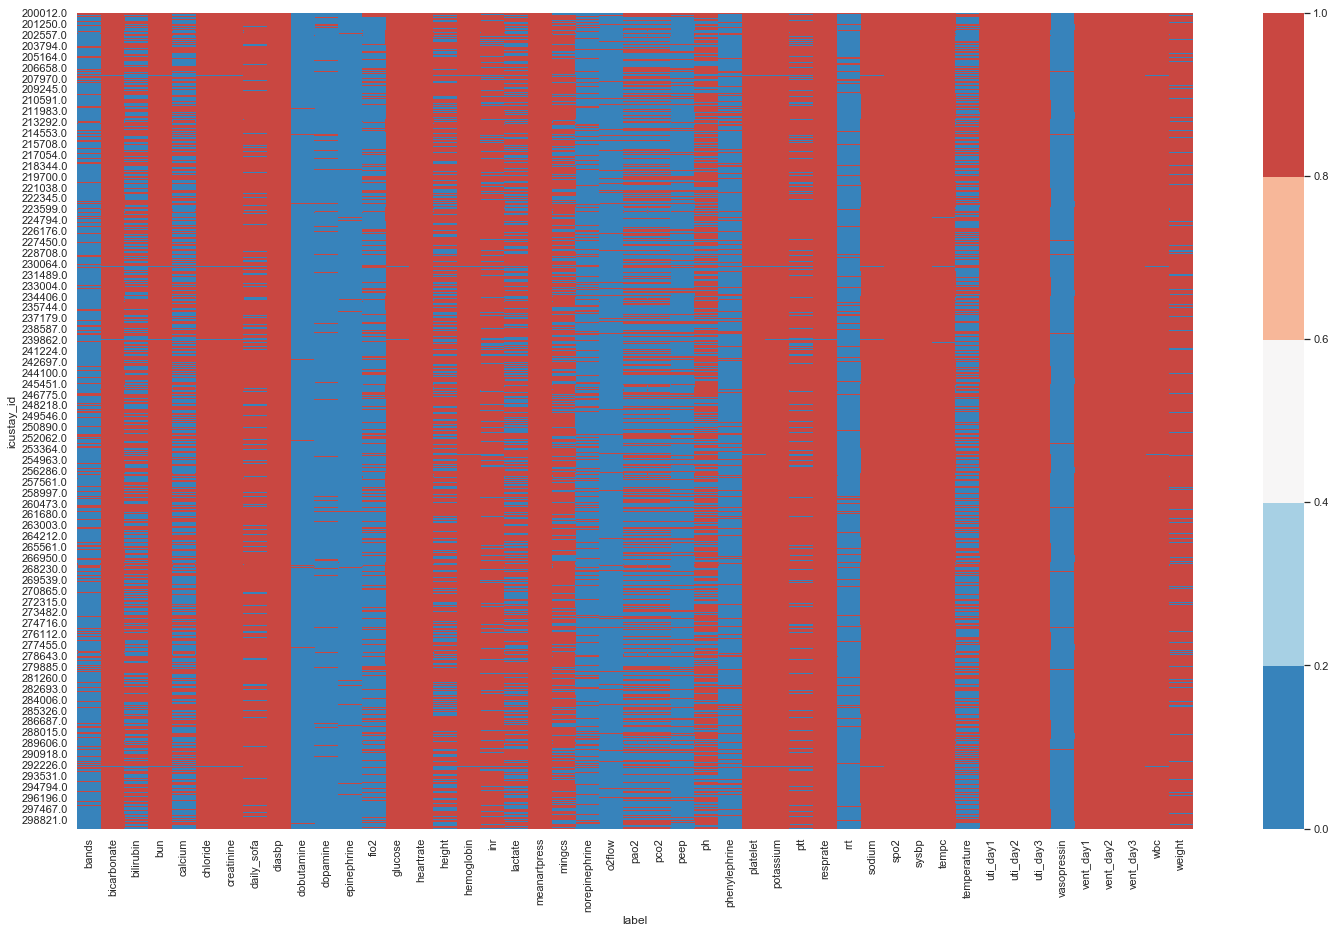

time: 2.86 s


In [410]:
#big_agg_min

#%matplotlib inline

# Index= ['aaa', 'bbb', 'ccc', 'ddd', 'eee']
# Cols = ['A', 'B', 'C', 'D']
# df = DataFrame(abs(np.random.randn(5, 4)), index=Index, columns=Cols)

sns.set(rc={'figure.figsize':(25,15)})
big_agg_count= big_agg_count.fillna(0)
big_agg_count = big_agg_count[big_agg_count.columns].astype(float) 


sns.heatmap(big_agg_countT,vmin=0, vmax=1, cmap=sns.color_palette("RdBu_r", 5))

In [192]:
sns.heatmap(big_agg_countT,vmin=0, vmax=1, cmap=sns.color_palette("RdBu_r", 5))

NameError: name 'big_agg_countT' is not defined

time: 223 ms


In [419]:
len(list(big_agg_count)) #47 columns. 

47

time: 1.94 ms


In [422]:
big_agg_pt_missing= big_agg_count.T.apply(lambda x:100*(47-sum(x))/47)
big_agg_pt_missing= pd.DataFrame(big_agg_pt_missing).rename(index=str, columns={0:'%_of_values_missing'})

time: 361 ms


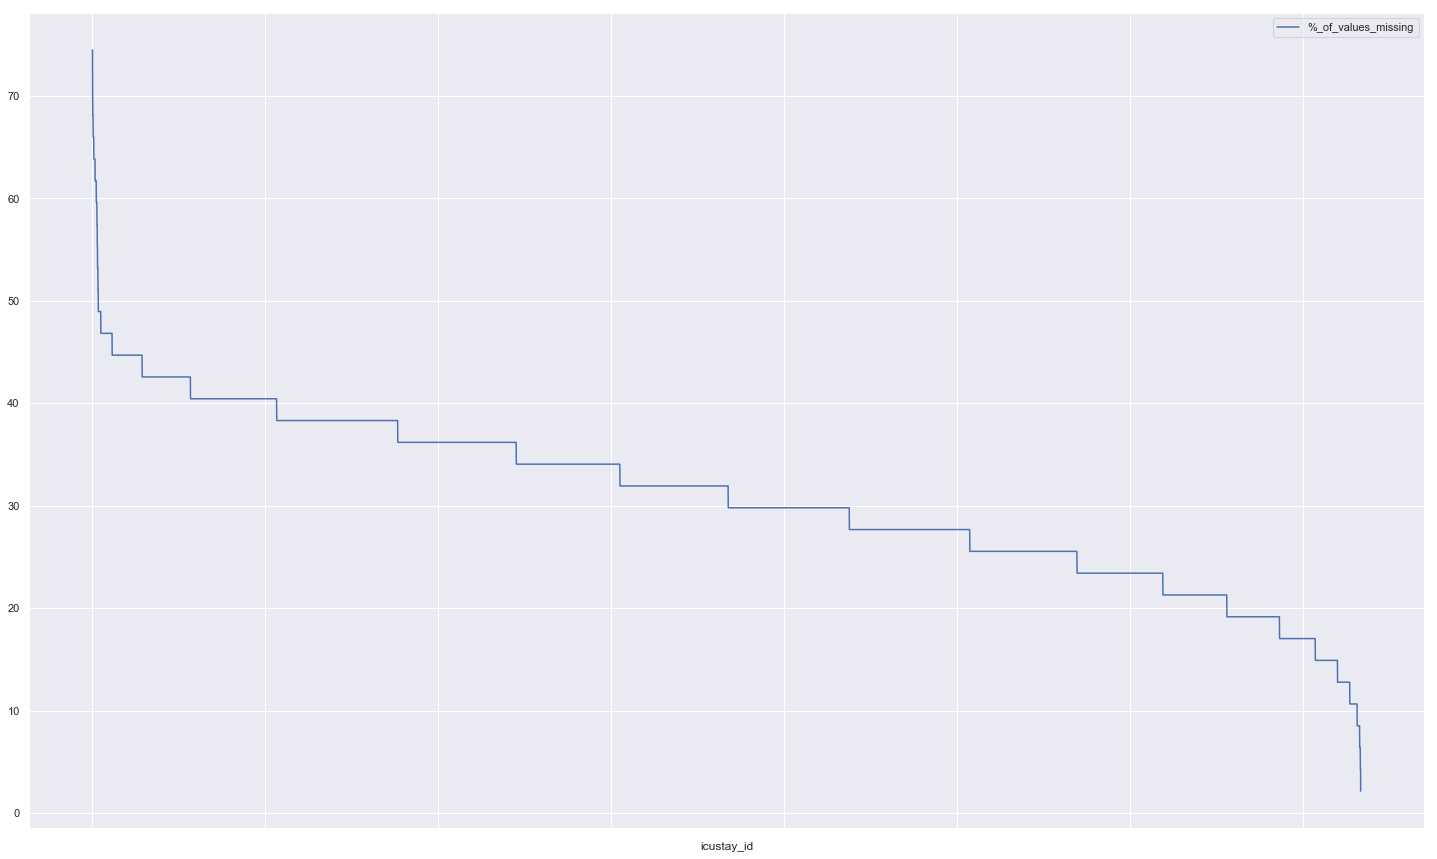

time: 342 ms


In [431]:
big_agg_pt_missing.sort_values('%_of_values_missing',ascending=False).plot()

In [434]:
len(big_agg_pt_missing)

14668

time: 2.19 ms


In [432]:
big_agg_pt_missing.describe()

,%_of_values_missing
count,14668.000000
mean,30.796523
std,8.164197
min,2.127660
25%,25.531915
50%,31.914894
75%,36.170213
max,74.468085


time: 12.9 ms


In [413]:
big_agg_count[big_agg_count>0] =1

time: 12.8 ms


In [336]:
big_agg_min.isnull()

label,bands,bicarbonate,bilirubin,bun,calcium,chloride,creatinine,daily_sofa,diasbp,dobutamine,...,temperature,uti_day1,uti_day2,uti_day3,vasopressin,vent_day1,vent_day2,vent_day3,wbc,weight
icustay_id,,,,,,,,,,,,,,,,,,,,,
200012.0,False,True,True,True,True,True,True,False,False,True,...,True,False,False,False,True,False,False,False,False,False
200014.0,True,False,True,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
200019.0,True,False,True,False,True,False,False,False,False,True,...,True,False,False,False,True,False,False,False,False,False
200030.0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
200033.0,True,False,True,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
200036.0,True,False,True,False,True,False,False,False,False,True,...,True,False,False,False,True,False,False,False,False,False
200055.0,True,False,False,False,False,False,False,False,False,True,...,True,False,False,False,True,False,False,False,False,False
200059.0,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
200061.0,True,False,False,False,True,False,False,False,False,True,...,True,False,False,False,True,False,False,False,False,False


time: 151 ms


In [330]:
big_agg2.pivot?

time: 17.5 ms


Signature: big_agg2.pivot(index=None, columns=None, values=None)
Docstring:
Return reshaped DataFrame organized by given index / column values.

Reshape data (produce a "pivot" table) based on column values. Uses
unique values from specified `index` / `columns` to form axes of the
resulting DataFrame. This function does not support data
aggregation, multiple values will result in a MultiIndex in the
columns. See the :ref:`User Guide <reshaping>` for more on reshaping.

Parameters
----------
index : string or object, optional
    Column to use to make new frame's index. If None, uses
    existing index.
columns : string or object
    Column to use to make new frame's columns.
values : string, object or a list of the previous, optional
    Column(s) to use for populating new frame's values. If not
    specified, all remaining columns will be used and the result will
    have hierarchically indexed columns.

    .. versionchanged :: 0.23.0
       Also accept list of column names.

Returns

In [ ]:
def sum_(x):
    try:
        return np.sum(x)
    except:
        return np.nan

def max_(x):
    try:
        return np.max(x)
    except:
        return np.nan

## data types

In [166]:
list1=[]
list2=[]
for element in df_list:
    if 'value' in (list(dfs[element])):
        list1.append(element)
    if 'valuenum' in (list(dfs[element])):
        list2.append(element)




time: 6.57 ms


In [176]:
for element in list2:
    print(dfs[element].groupby('label')['valuenum'].describe())

               count        mean        std     min     25%     50%     75%  \
label                                                                         
BICARBONATE    702.0   22.825641   6.487323    4.00   19.00   23.00   26.00   
CALCIUM      29928.0    1.116073   0.116103    0.25    1.06    1.12    1.17   
CHLORIDE      4733.0  105.783858   7.086799   59.00  102.00  106.00  110.00   
GLUCOSE      20228.0  137.054430  58.462186   10.00  104.00  126.00  155.00   
HEMOGLOBIN    8559.0   10.188912   2.062006    1.20    8.80   10.10   11.40   
LACTATE      34490.0    2.899805   2.925546    0.05    1.20    1.90    3.30   
PH           70821.0    7.366439   0.092541    6.37    7.32    7.38    7.43   
POTASSIUM    19237.0    4.207316   0.795655    1.20    3.70    4.10    4.60   
SODIUM        6678.0  136.876310   5.506295  109.00  134.00  137.00  139.00   
TEMPERATURE  23720.0   37.167323   1.060169   29.20   36.60   37.20   37.80   

                 max  
label                 
BICAR

In [177]:
for element in list1:
    print(dfs[element].groupby('label')['value'].describe())

          count unique             top   freq
label                                        
uti_day1  14668      2  Neg/Not_tested  12940
uti_day2  14668      2  Neg/Not_tested  14212
uti_day3  14668      2  Neg/Not_tested  14275
          count       mean        std  min   25%   50%   75%    max
label                                                              
weight  13325.0  80.740671  25.134251  1.0  64.5  77.0  91.6  575.0
                  count      mean       std       min       25%       50%  \
label                                                                       
dobutamine       1573.0  5.496201  4.211357  0.249004  2.500000  4.959350   
dopamine         5699.0  7.084736  4.991323  0.300000  3.000000  5.000000   
epinephrine      2052.0  0.055334  0.084428  0.004000  0.020000  0.030000   
norepinephrine  23649.0  0.169422  0.171888  0.000113  0.050000  0.108844   
phenylephrine   15783.0  1.626640  1.506740  0.010000  0.500135  1.000537   
vasopressin      3906.0  1.

In [170]:
dfs['bg_ART'].groupby('label')['valuenum'].apply(lambda x: type(x))

label
BICARBONATE    <class 'pandas.core.series.Series'>
CALCIUM        <class 'pandas.core.series.Series'>
CHLORIDE       <class 'pandas.core.series.Series'>
GLUCOSE        <class 'pandas.core.series.Series'>
HEMOGLOBIN     <class 'pandas.core.series.Series'>
LACTATE        <class 'pandas.core.series.Series'>
PH             <class 'pandas.core.series.Series'>
POTASSIUM      <class 'pandas.core.series.Series'>
SODIUM         <class 'pandas.core.series.Series'>
TEMPERATURE    <class 'pandas.core.series.Series'>
Name: valuenum, dtype: object

time: 47.9 ms
